In [76]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

__Set Parameters for Loading Data + Analysis:__

In [55]:
#set file path of data folder
data_path = '../data/'

#set BC subtype to analyze
subtype = "HER2+" #options are "HER2+", "ER+", or "TNBC"

#set QC thresholds
nfeature_min = 200
nfeature_max = 2500
ncount_min = 500
percent_mt_max = 10

__Edit Data Into Correct Formatting__:
    
Data files need to be edited into a readable format before analysis can begin

1) genes.tsv

In [3]:
#load gene names file
df_genes = pd.read_csv('../data/genes.tsv', sep='\t', header=None, names=['GeneName'])

#create gene ID column
df_genes['GeneID'] = ['Gene_' + str(i) for i in range(len(df_genes))]

#order columns to match scanpy format
df_genes = df_genes[['GeneID', 'GeneName']]

#save to genes.tsv
df_genes.to_csv('../data/genes.tsv', sep='\t', index=False, header=False)

#load tsv file into DataFrame
df = pd.read_csv('../data/genes.tsv', sep='\t', header = None)
#print(df.head())

In [7]:
#read in data
adata = sc.read_10x_mtx(data_path, var_names='gene_symbols', cache=True)
#print(adata)

AnnData object with n_obs × n_vars = 100064 × 29733
    var: 'gene_ids'


2) metadata.csv

In [20]:
#load in metadata
metadata = pd.read_csv(data_path + 'metadata.csv')

In [22]:
#create cell_id header for unique cell identifiers
new_headers = ['cell_id'] + list(metadata.columns[1:])

In [24]:
#assign cell_id header to cells
metadata.columns = new_headers
#print(metadata.head())

In [34]:
#save metadata w/header
metadata.to_csv(data_path + 'metadata.csv', index=False)

In [40]:
#merge data + metadata by cell_id
adata.obs = adata.obs.join(metadata.set_index('cell_id'))
#print(adata.obs.head())

__Set AnnData Object for Downstream Analysis:__

In [44]:
#set copy of raw data
adata.raw = adata

__QC and Subsetting:__

In [59]:
#calculate % mitochondrial DNA per sample
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt'] = adata[:, mito_genes].X.sum(axis=1) / adata.X.sum(axis=1) * 100
#print(adata.obs.head())

                         orig.ident  nCount_RNA  nFeature_RNA  percent.mito  \
CID3586_AAGACCTCAGCATGAG    CID3586        4581          1689      1.506221   
CID3586_AAGGTTCGTAGTACCT    CID3586        1726           779      5.793743   
CID3586_ACCAGTAGTTGTGGCC    CID3586        1229           514      1.383238   
CID3586_ACCCACTAGATGTCGG    CID3586        1352           609      1.923077   
CID3586_ACTGATGGTCAACTGT    CID3586        1711           807     13.325541   

                         subtype    celltype_subset     celltype_minor  \
CID3586_AAGACCTCAGCATGAG   HER2+  Endothelial ACKR1  Endothelial ACKR1   
CID3586_AAGGTTCGTAGTACCT   HER2+  Endothelial ACKR1  Endothelial ACKR1   
CID3586_ACCAGTAGTTGTGGCC   HER2+  Endothelial ACKR1  Endothelial ACKR1   
CID3586_ACCCACTAGATGTCGG   HER2+  Endothelial ACKR1  Endothelial ACKR1   
CID3586_ACTGATGGTCAACTGT   HER2+  Endothelial ACKR1  Endothelial ACKR1   

                         celltype_major  percent_mt  
CID3586_AAGACCTCAGCATGAG  

In [61]:
#filter samples based on QC metrics
adata = adata[(
    (adata.obs['nFeature_RNA'] > nfeature_min) &
    (adata.obs['nFeature_RNA'] < nfeature_max) &
    (adata.obs['nCount_RNA'] > ncount_min) &
    (adata.obs['percent_mt'] < percent_mt_max)
)]

In [63]:
#set samples to analyze to specified subtype
adata = adata[adata.obs['subtype'] == subtype]

__Normalization:__

In [72]:
sc.pp.normalize_total(adata, target_sum=1e6)

/Users/joshuagalla/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


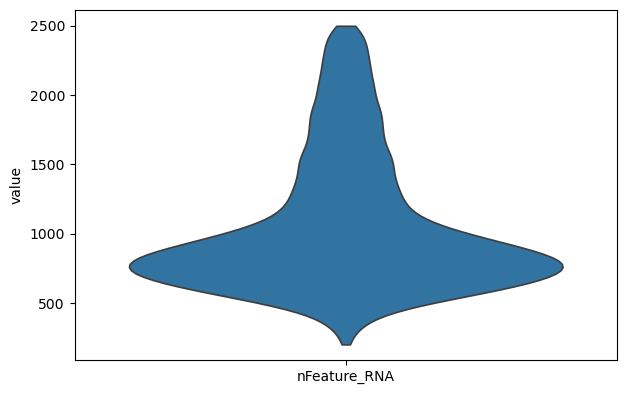

In [96]:
sc.pl.violin(adata, ['nFeature_RNA'], stripplot = False)
plt.show()

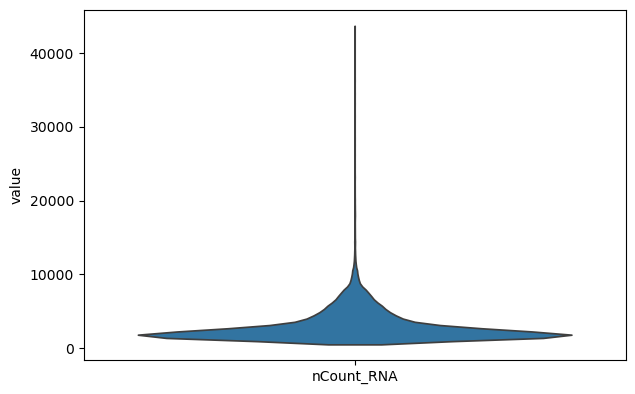

In [98]:
sc.pl.violin(adata, ['nCount_RNA'], stripplot = False)
plt.show()